# 🧬 Protein in Water Simulation with OpenMM
This notebook demonstrates how to simulate a protein in an explicit water box using OpenMM. We'll cover steps such as loading a PDB file, setting up the force field, solvating the protein, energy minimization, and running dynamics.

In [18]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

### Load the PDB File
Here we load a protein structure in PDB format. You can replace the path with your own file if you're working with a different structure.

In [19]:
pdb = PDBFile("1AKI.pdb")

### Forcefields in Molecular Dynamics

Forcefields are mathematical models used to estimate the potential energy of a system of particles, typically atoms or molecules. They define how the particles interact with each other through bonded (e.g., bonds, angles, dihedrals) and non-bonded (e.g., van der Waals, electrostatic) interactions. 

In this notebook, we simulate a simple protein, Lysozyme, using the AMBER14 (Assisted Model Building with Energy Refinement) forcefield. 

In [20]:
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

### Modeller to Fix Structure
This step prepares the PDB for simulation with Modeller

In [21]:
#Preprocessing the pdb file.
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, padding=1.0*nanometer)

### Simulation Setup: System and Integrator

In this block, we configure essential components for the molecular dynamics (MD) simulation: the **force field settings**, the **integrator**, and the **simulation object**. Each element controls different physical and numerical aspects of the simulation.

---

#### `constraints=HBonds`

This setting applies constraints to all **bond lengths involving hydrogen atoms**, which allows the simulation to take larger time steps (commonly 2–4 fs) without sacrificing stability. Hydrogen-involved bonds tend to vibrate rapidly, so constraining them removes the need to resolve these high-frequency motions.

---

#### `nonbondedCutoff=1.0*nanometer`

This defines the **cutoff distance** for evaluating nonbonded interactions (like van der Waals forces). Atoms farther than this distance from each other won't have their interactions calculated directly. Instead, **long-range electrostatics** are handled by:

---

#### `nonbondedMethod=PME`

PME stands for **Particle Mesh Ewald**, a highly efficient algorithm for computing **long-range electrostatic interactions** in periodic systems. PME divides the computation between real-space (short-range) and reciprocal-space (long-range) components, making it accurate and scalable for large biomolecular simulations.

---

#### `LangevinMiddleIntegrator`

This integrator performs **Langevin dynamics**, which combines:
- Newtonian motion
- Friction 
- Random noise (to maintain a desired temperature)

It acts as both an **integrator** and a **thermostat**, keeping the system at a specified temperature. The `LangevinMiddleIntegrator` is a newer variant with improved numerical stability and energy conservation.

The motion of a particle in a Langevin thermostat is governed by:


$$
m \frac{d^2 \mathbf{x}}{dt^2} = -\nabla U(\mathbf{x}) - \gamma m \frac{d \mathbf{x}}{dt} + \sqrt{2 \gamma m k_B T} \cdot \mathbf{R}(t)
$$

Where:

- $m$: mass of the particle  
- $mathbf{x}$: position  
- $U(\mathbf{x})$: potential energy  
- $\gamma$: friction (damping) coefficient  
- $T$: temperature  
- $k_B$: Boltzmann constant  
- $\mathbf{R}(t)$: Gaussian random force, with
  - $\langle \mathbf{R}(t) \rangle = 0$
  - $\langle \mathbf{R}(t)\mathbf{R}(t') \rangle = \delta(t - t')$



In [22]:
# Create a system. Here we define some forcefield settings such as the nonbonded method
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)

# Define the integrator. The Langevin integrator is also a thermostat
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
#simulation.context.setVelocitiesToTemperature(300*kelvin)

In [23]:
# Now minimize energy
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


### Output and Reporting: Trajectory and Simulation Logs

To monitor and analyze our molecular dynamics (MD) simulation, we attach **reporters** to the `Simulation` object. Reporters automatically save structural and state data at specified intervals.


In [24]:
# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))

In [25]:
# NVT Equilibration
print('Running NVT')
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-361463.3361178527,295.8070234081221,237.748379851506
2000,-357503.4806491027,297.2545932782702,237.748379851506
3000,-357870.8615084777,301.63376034744243,237.748379851506
4000,-358266.2833834777,300.7332940357894,237.748379851506
5000,-358773.6290866027,303.04435961811004,237.748379851506
6000,-359067.4767428527,301.8199861003728,237.748379851506
7000,-357874.2755709777,302.8335024641075,237.748379851506
8000,-358369.2990084777,297.71638272526246,237.748379851506
9000,-357879.4650241027,299.9154649264658,237.748379851506
10000,-358134.4376803527,302.2597009476066,237.748379851506


### Pressure Control with `MonteCarloBarostat`: Running NPT Simulations

In this section, we enable **pressure coupling** to simulate the system in the **NPT ensemble** — constant **Number of particles (N)**, **Pressure (P)**, and **Temperature (T)**.

---

#### `MonteCarloBarostat(1*bar, 300*kelvin)`

This adds a **barostat** to the system, which attempts to keep the **pressure** close to 1 bar by **periodically proposing changes to the simulation box volume**. It accepts or rejects these changes based on a Monte Carlo criterion that preserves the proper statistical ensemble.

##### How It Works:
- Every fixed number of steps (default is every 25 steps), the barostat proposes a small volume change.
- This change is **accepted or rejected** using a **Metropolis criterion**, ensuring detailed balance and proper ensemble sampling.
- Works best in systems with **periodic boundary conditions** and solvent (like water boxes).

---


#### `simulation.context.reinitialize(preserveState=True)`

After adding the barostat, we **reinitialize the simulation context** so that the barostat takes effect. The `preserveState=True` argument ensures that positions, velocities, and time are **not reset** during reinitialization.

---

#### ▶️ Running the Simulation

```python
simulation.step(10000)


In [26]:
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)
print("Running NPT")
simulation.step(10000)

Running NPT
11000,-360642.0696657398,301.20692044781305,230.94574399171535
12000,-360331.37299006735,299.3853354084557,227.12487301164174
13000,-361316.11963261315,303.67884986257474,224.74040323960878
14000,-361039.3792708223,300.24463063911355,224.79283331141616
15000,-361285.0315064341,303.21080886419855,225.44708280708733
16000,-362304.17164420686,303.3645613676301,225.40747396082972
17000,-360848.58983638976,297.2623118378268,225.753588716614
18000,-360398.0919744761,299.5290312407302,226.0201538747081
19000,-360745.36612044135,300.58323049101585,225.40922057224353
20000,-361613.35235625226,299.15256810920965,224.98994449200384


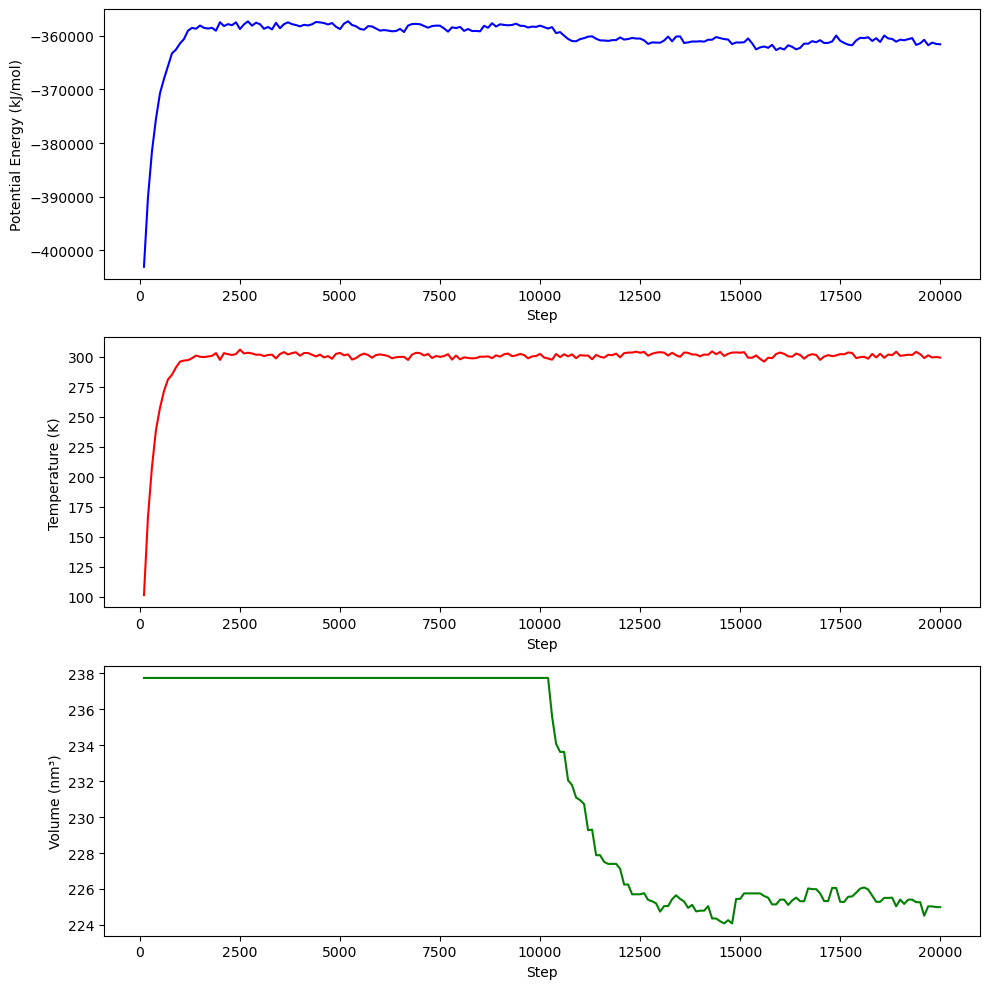

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data and extract 
data = np.loadtxt('md_log.txt', delimiter=',')
step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

# Potential Energy
plt.figure(figsize=(10, 10)) 
plt.subplot(3, 1, 1) 
plt.plot(step, potential_energy, color='b', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Potential Energy (kJ/mol)")

# Temperature
plt.subplot(3, 1, 2) 
plt.plot(step, temperature, color='r', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")

# Volume
plt.subplot(3, 1, 3) 
plt.plot(step, volume, color='g', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Volume (nm³)")
plt.tight_layout()
plt.show()


### Checkpointing!!

Helps in restarting failed simulations; progress monitoring; resource management and parameter tuning.

Checkpointing is a crucial feature in molecular dynamics simulations - it involves saving the current state of the simulation to disk, allowing it to be resumed from the same point later. This functionality is relevant for several reasons:

In [28]:
#CHECKPOINTING!
# Save the toplogy as a PDB file.
with open('topology.pdb', 'w') as output:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(),output)

# save a serialized version of the system. This stores the forcefield parameters. We will come back to use this later.
with open('system.xml', 'w') as output:
    output.write(XmlSerializer.serialize(system))

# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors. 
# It will save a checkpoint every 1000 timesteps.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))
#We can make simulations run for a certain amount of wall-time
simulation.runForClockTime(20.0*seconds)

21000,-361254.9782273781,299.60956628856957,224.96898146838913
22000,-362067.8356679233,302.7879256340097,224.58800307905878
23000,-361069.2707627255,299.96928524476886,224.67549470802854
24000,-360746.3520218963,296.8714795261651,224.10449605522214
25000,-361349.1570044081,300.84187795189564,224.41563145087983
26000,-360771.745071806,303.89222561480625,225.1757820305408
27000,-361257.52984304144,302.31673721995446,225.10481609008386
28000,-361629.62200314645,301.4622936922649,224.58784025606428
29000,-360687.1071791928,296.48206288967896,225.7846959839198
30000,-361194.30974668404,300.10587866760983,225.5336972819497
31000,-360915.6252221272,299.8960952166492,224.23647810004147
32000,-361897.1365981647,296.48176039902046,224.050067723881
33000,-361546.14287270326,305.2202629629074,224.57228146032153
34000,-360783.1240984837,299.1975628275562,225.09797164980574
35000,-362031.3008422062,298.9651654727356,224.87181029830123
36000,-361636.3607779932,304.88195036746816,224.19571989419754
3

In [29]:
#Loading the checkpoint file and continuing the simulation.

pdb = PDBFile('topology.pdb')

with open('system.xml') as input:
    system = XmlSerializer.deserialize(input.read())

# Define the integrator.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(pdb.topology, system, integrator)

# set the positions, velocities, and box vectors from the checkpoint file
simulation.loadCheckpoint('checkpoint.chk')

# We still need to define the reporters again

# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))

# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

# write the code to run for 20 seconds of wall clock time
simulation.runForClockTime(20.0*seconds)

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
39000,-362338.370150693,299.9858646703038,224.9314575691221
40000,-362237.70816432126,299.22090433693666,224.13368220546155
41000,-361229.1007502894,302.8145812507249,224.89600119213168
42000,-360890.3450713274,300.767408607766,224.7589272667113
43000,-362154.42505003395,298.6773524014294,223.97903561053005
44000,-361673.39348640456,300.552446758936,225.826799317453
45000,-360996.8552860874,304.0201841237993,225.1509934311821
46000,-361492.4411716042,300.0887363969257,224.45321018374
47000,-361890.02272566105,302.99523340773624,224.25677559333465
48000,-362044.37911317335,301.0496470474712,224.95592221869785
49000,-361239.98329719156,299.7899938161689,225.48777485733845


In [30]:
# Number of iterations
num_iterations = 5

for i in range(num_iterations):
    print(f"Running iteration {i+1}/{num_iterations}")
    pdb = PDBFile('topology.pdb')
    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # We still need to define the reporters again

    # Write trajectory to a file called traj.dcd every 1000 steps
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

    # Print state information to the screen every 1000 steps
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True, volume=True))

    # Print the same info to a log file every 100 steps
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True, potentialEnergy=True, temperature=True, volume=True, append=True))

    # Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

    # write the code to run for 20 seconds of wall clock time
    simulation.runForClockTime(20.0*seconds)

Running iteration 1/5
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
50000,-361080.135537755,299.9160069839878,224.93987831942826
51000,-361097.9757072972,300.3082453932782,224.30736802839553
52000,-360661.0788375563,300.47611162929246,224.3324469054669
53000,-361522.8331553368,299.01058876922303,225.88350958074759
54000,-361245.99160566484,303.12973596156206,224.8270184675461
55000,-361073.29778845375,299.25969934017115,226.04846616494015
56000,-362247.3779053332,302.73790292023165,224.5050554119785
57000,-361088.4168673649,302.6829253726779,225.82462545785415
58000,-361169.1680510873,300.62284513798994,225.37781790560746
59000,-361032.0654495617,300.2007222511723,225.35324598200276
60000,-361237.2247686777,298.50193631136557,224.1399952230252
61000,-362223.3848028332,301.1342888268777,225.63753796284732
Running iteration 2/5
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
62000,-361235.0479606786,299.40449614858954,225.8551411829

### Ramping Up Temperature in Each Iteration

In this example, we will slowly ramp up temperature in our simulation to reach a certain desired value.

In [31]:
# Number of iterations
num_iterations = 5
a=5
for i in range(num_iterations):
    print(f"Running iteration {i+1}/{num_iterations}")
    pdb = PDBFile('topology.pdb')
    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())
    
    temperature = 300+(a*i)
    # Define the integrator.
    integrator = LangevinMiddleIntegrator(temperature, 1/picosecond, 0.004*picoseconds)
    simulation.context.setParameter(MonteCarloBarostat.Temperature(), temperature)

    # Create the Simulation
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # We still need to define the reporters again

    # Write trajectory to a file called traj.dcd every 1000 steps
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

    # Print state information to the screen every 1000 steps
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True, volume=True))

    # Print the same info to a log file every 100 steps
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True, potentialEnergy=True, temperature=True, volume=True, append=True))

    # Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

    # write the code to run for 20 seconds of wall clock time
    simulation.runForClockTime(20.0*seconds)

Running iteration 1/5
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
110000,-360588.33046282246,301.2886614147091,224.58548510582892
111000,-361606.546885591,301.5652375757049,225.08456865171212
112000,-362570.8940360935,303.044078924897,224.59531739821247
113000,-361638.81614443706,298.6317448547349,224.1932610724869
114000,-361508.96755700116,303.57122209902843,224.92337557348762
115000,-361833.3236109889,301.1953484747963,225.08980226023345
116000,-361120.71299052984,299.8527208878469,224.62383292593918
117000,-361197.62781641097,302.1740857004315,224.5304071960938
118000,-361715.99914216273,298.63843282135184,224.47296513327092
119000,-361599.4485504476,302.22146867872016,226.25573332527514
120000,-361533.6593575855,302.20438147352587,223.58510312125898
121000,-361661.7137986708,303.75452766723265,224.48538689526507
122000,-362274.8527915953,297.6313536455522,224.7824454272679
123000,-362029.78689060244,300.9519106819555,225.26871392248162
124000,-361215

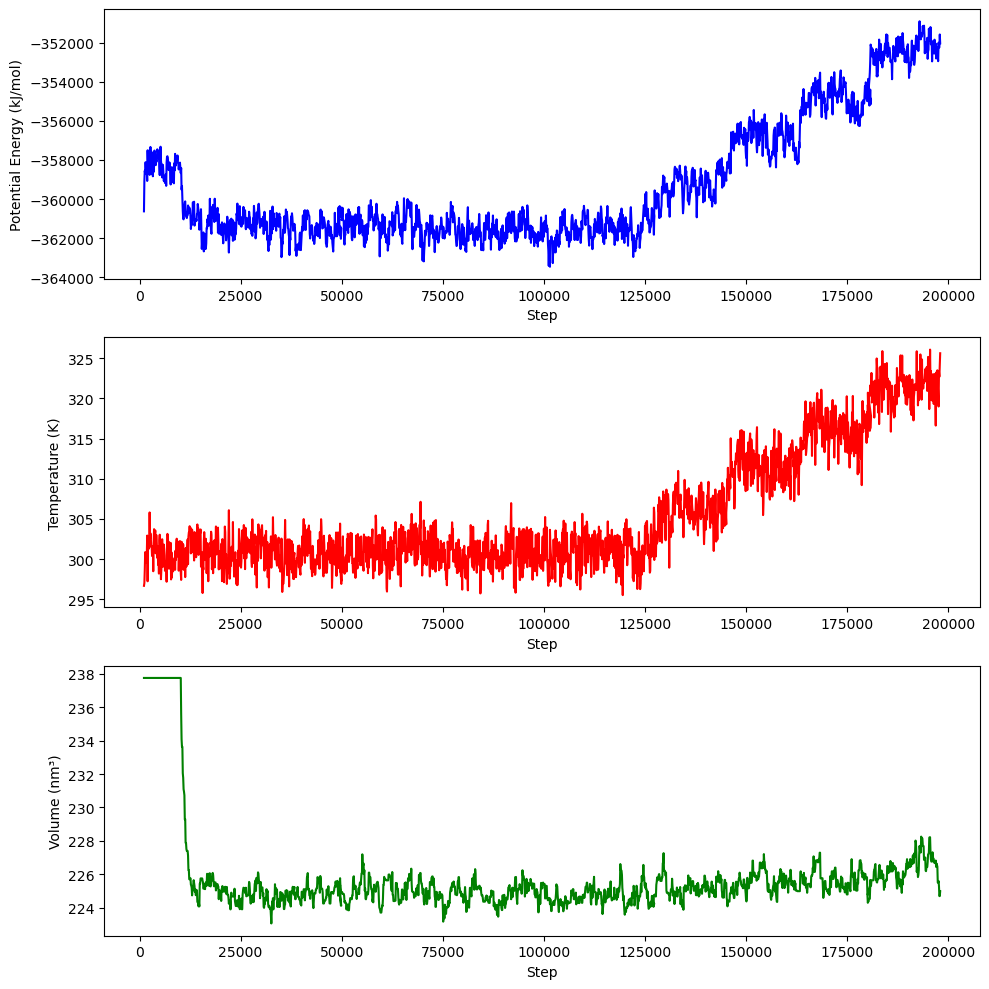

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data and extract 
data = np.loadtxt('md_log.txt', delimiter=',')
step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

# Potential Energy
plt.figure(figsize=(10, 10)) 
plt.subplot(3, 1, 1) 
plt.plot(step[10:], potential_energy[10:], color='b', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Potential Energy (kJ/mol)")

# Temperature
plt.subplot(3, 1, 2) 
plt.plot(step[10:], temperature[10:], color='r', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")

# Volume
plt.subplot(3, 1, 3) 
plt.plot(step[10:], volume[10:], color='g', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Volume (nm³)")
plt.tight_layout()
plt.show()

In [33]:
# What if I want to now ramp up pressure?
# Number of iterations
num_iterations = 5
initial_pressure = 1 * bar
# Just for fun, let's increase the pressure by 1000 bar each iteration
pressure_increment = 1000 * bar
temperature=320*kelvin
for i in range(num_iterations):
    print(f"Running iteration {i+1}/{num_iterations}")
    pdb = PDBFile('topology.pdb')
    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(temperature, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')
    # Add the MonteCarloBarostat with increasing pressure
    pressure = initial_pressure + i * pressure_increment
    simulation.context.setParameter(MonteCarloBarostat.Temperature(), temperature)
    simulation.context.setParameter(MonteCarloBarostat.Pressure(), pressure)

    # We still need to define the reporters again

    # Write trajectory to a file called traj.dcd every 1000 steps
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

    # Print state information to the screen every 1000 steps
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True, volume=True))

    # Print the same info to a log file every 100 steps
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True, potentialEnergy=True, temperature=True, volume=True, append=True))

    # Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

    # write the code to run for 20 seconds of wall clock time
    simulation.runForClockTime(20.0*seconds)

Running iteration 1/5
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
199000,-353220.3200439082,320.1695300328329,225.37976819930105
200000,-351979.2416318066,320.20027345502103,227.37570669224763
201000,-353005.4413970832,321.8892417199606,226.74178365124112
202000,-351253.2030505126,322.5120261950395,227.19689941949483
203000,-352047.6524025439,317.8527833734897,226.83721715769508
204000,-352717.83615532354,321.72940440202325,227.18885319677165
205000,-351210.4032546205,319.2919021971073,227.49970433586373
206000,-352291.4912577607,320.4298988509386,226.6558907014944
207000,-352574.60019565094,322.27136119615204,227.40540831193806
208000,-352202.7347532406,323.1413957222323,226.99247301679102
209000,-351954.2751470504,322.54059496701996,227.40082458746832
210000,-352990.98639701586,321.8412381557312,227.72451212323082
211000,-352690.2315835261,315.97516648895817,227.5021664644236
212000,-351864.9163661499,324.6276835085682,227.15957992181447
213000,-351836.

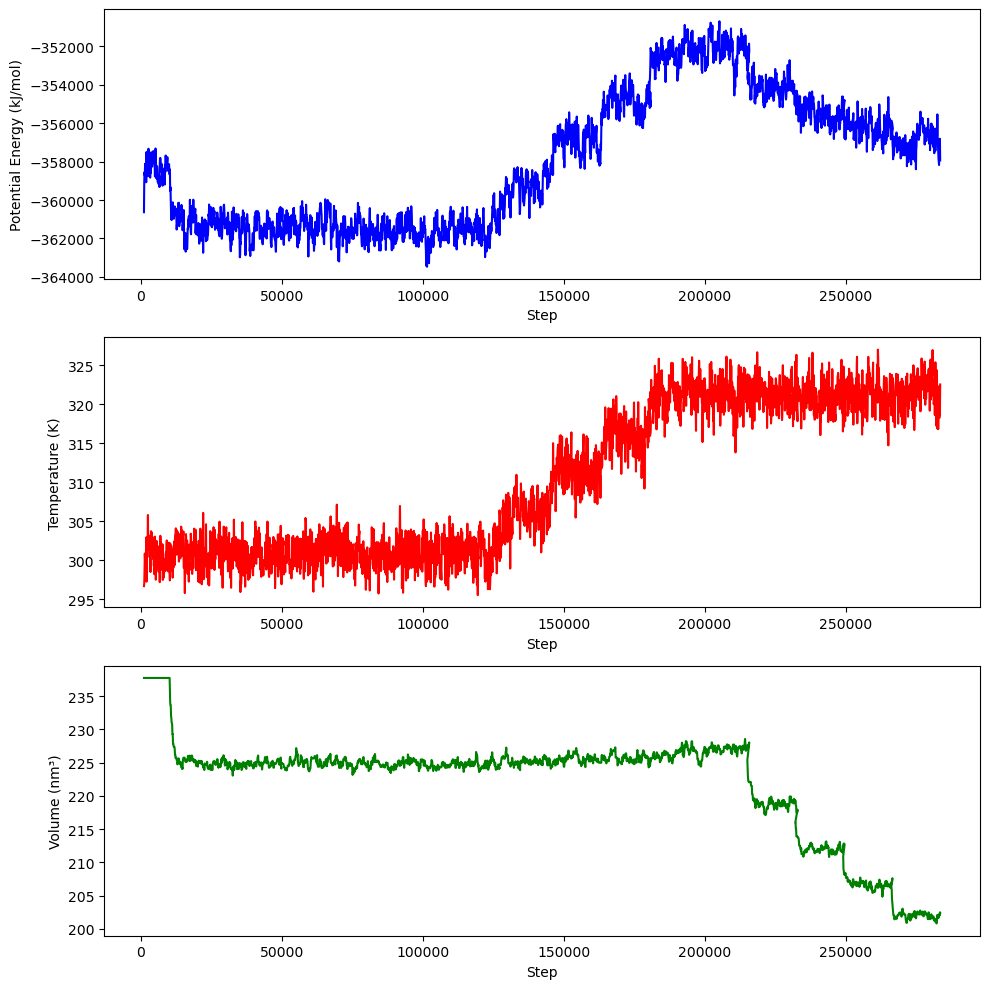

In [34]:
# Load the data and extract 
data = np.loadtxt('md_log.txt', delimiter=',')
step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

# Potential Energy
plt.figure(figsize=(10, 10)) 
plt.subplot(3, 1, 1) 
plt.plot(step[10:], potential_energy[10:], color='b', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Potential Energy (kJ/mol)")

# Temperature
plt.subplot(3, 1, 2) 
plt.plot(step[10:], temperature[10:], color='r', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")

# Volume
plt.subplot(3, 1, 3) 
plt.plot(step[10:], volume[10:], color='g', linewidth=1.5)
plt.xlabel("Step")
plt.ylabel("Volume (nm³)")
plt.tight_layout()
plt.show()